In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

data = load_boston()
data.keys()

/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing da

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

In [2]:
data["feature_names"]

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [3]:
X, y = data["data"], data["target"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = pd.DataFrame(X_train,columns=data["feature_names"])
X_test = pd.DataFrame(X_test,columns=data["feature_names"])
y_train = pd.DataFrame(y_train,columns=["target"])
y_test = pd.DataFrame(y_test,columns=["target"])

In [5]:
#SGD: stochatic gradient descent (linear regressor)
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate

cv_loss = []
cv_learning = []

shuffle=True
alpha = 100 # 100 # regularization and also affects parameter in 'optimal' learning rate
tol = 1e-4 # 1e-4 instead of le-3
eta0 = 1e-6 # 1e-6 # constant / initial learning rate (instead of le-8)
n_iter_no_change = 10 # 10 instead of 5
max_iter = 1000
epsilon = 0.1 # 0.01
power_t = 0.25 # 0.1, 2
penalty = 'l2'
for loss in ['squared_loss','huber','squared_epsilon_insensitive','epsilon_insensitive']:
    cv_loss.append(cross_validate(SGDRegressor(loss=loss, #sgd allows us to set the loss, we iterate over the loss set
                                               penalty=penalty, #default: l2 penalty
                                               shuffle=shuffle, #shuffle: against overfitting
                                               alpha=alpha, #alpha: here the standard parameter for regularization, affects the used parameter
                                               tol=tol,
                                               eta0=eta0, #used by all except optimal 
                                               n_iter_no_change=n_iter_no_change, #number of iterations where we see no change 
                                               max_iter=max_iter,
                                               epsilon=epsilon, #huber, insensitive, squared_insensitive
                                               power_t=power_t), #power_t: power for the power loss (invscaling)
                            X_train,
                            y_train,
                            cv = 5,# we will keep it at 5, since that gives each sample set around 80 samples
                            return_train_score = True,
                            return_estimator = True,
                            n_jobs = 2))


#now iteration over the different learning rates
for l_r in ['constant','optimal','invscaling','adaptive']: #optimal=inverse, invscaling=power

    cv_learning.append(cross_validate(SGDRegressor(learning_rate=l_r,
                                                   penalty=penalty,
                                                   shuffle=shuffle,
                                                   alpha=alpha,
                                                   tol=tol,
                                                   eta0=eta0,
                                                   n_iter_no_change=n_iter_no_change,
                                                   max_iter=max_iter,
                                                   epsilon=epsilon,
                                                   power_t=power_t),
                            X_train,
                            y_train,
                            cv = 5,# we will keep it at 5, since that gives each sample set around 80 samples
                            return_train_score = True,
                            return_estimator = True,
                            n_jobs = 2))
    
# default learning rates are very off, need to play around with normalizations, learning rates, and intial
# learning initialization to get to some sort of acceptable scores

# good example of where default parameters lead to completly wrong results

/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

In [6]:
# coefficients are massive with default values
print('coef:',cv_learning[2]["estimator"][0].coef_) #looking at the third element [2] of our learning rate (invscaling))
print('n_iter:',cv_learning[2]["estimator"][0].n_iter_)
#Not hitting anywhere near max_iter limit

coef: [-0.01204609  0.05177059 -0.00770643  0.00029535  0.00024476  0.00831782
  0.00514478  0.00322729 -0.00159468 -0.00454644  0.00495745  0.06088245
 -0.02115354]
n_iter: 21


In [7]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
print(ridge_reg.coef_)

[[-1.16807614e-01  4.60034842e-02 -2.37620690e-02  2.27814972e+00
  -8.55779612e+00  3.75513528e+00 -1.04143035e-02 -1.28009479e+00
   2.22037885e-01 -1.15255734e-02 -9.69288272e-01  8.53481709e-03
  -4.98849035e-01]]


In [8]:
def plotCVResults(cv_res, names):
    fig = plt.figure(figsize=(20,10))
    trainin_time_ax = fig.add_subplot(2,1,2)
    for i in range(4):
        name = names[i]
        df_reg = pd.DataFrame(cv_res[i])

        ax = fig.add_subplot(2,4,i+1)

        ax.set_title(name + " scores, adj. avg test: " + \
                     str(round(df_reg.loc[df_reg["test_score"]>0]["test_score"].mean(),2)))
        ax.set_xlabel("iteration")
        ax.set_ylabel("R2 score")
        ax.set_ylim(0,1)
        df_reg[["train_score","test_score"]].plot(ax=ax)

        df_reg["fit_time"].plot(ax=trainin_time_ax,label=name)

    plt.sca(trainin_time_ax)
    plt.legend()
    plt.show()

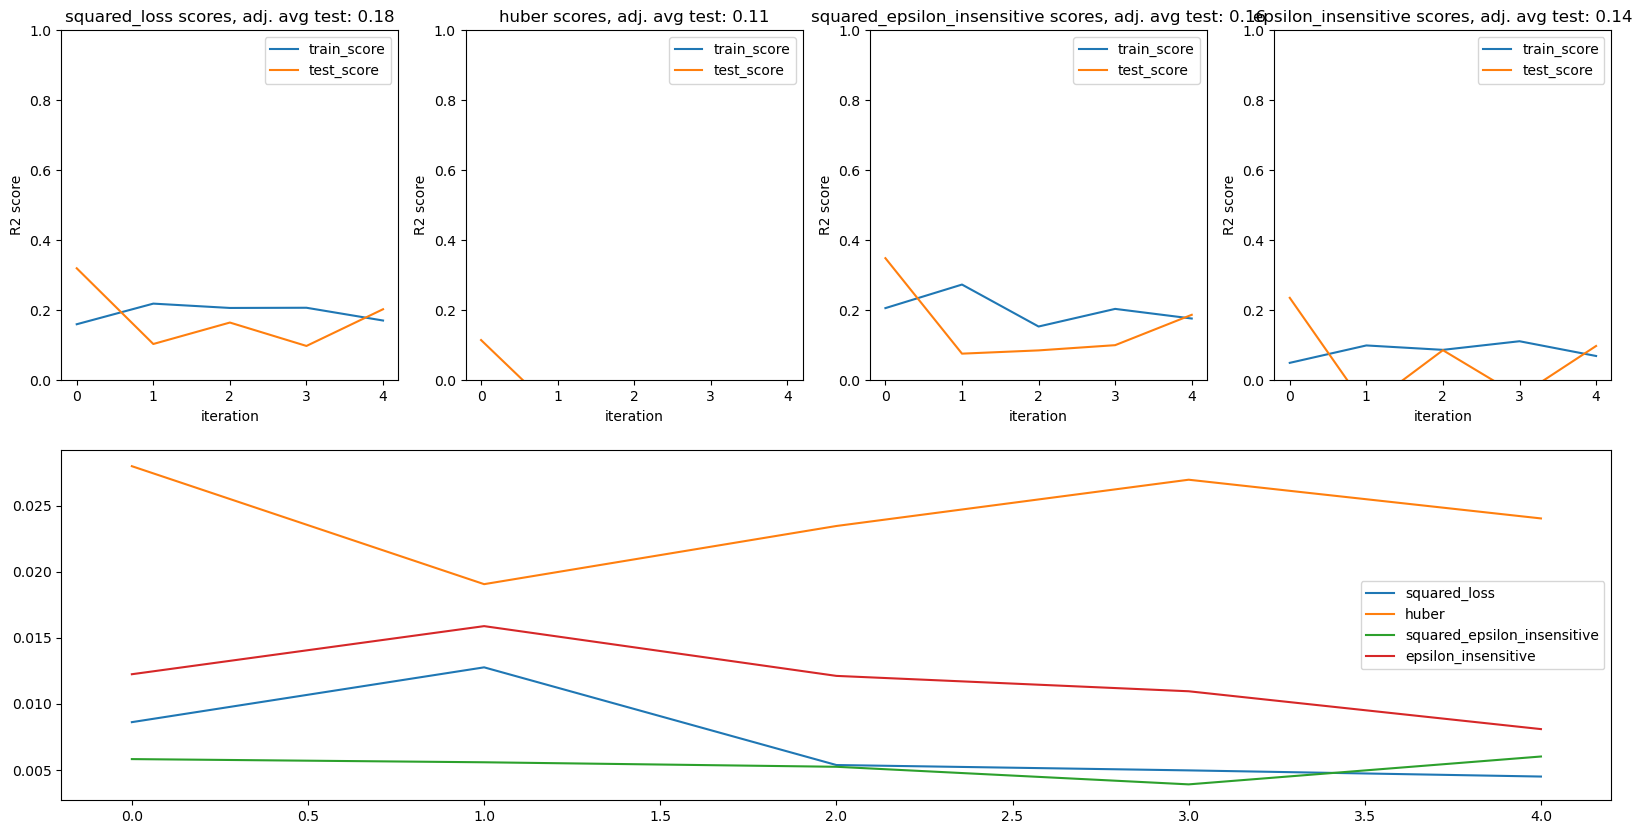

In [9]:
plotCVResults(cv_loss, ['squared_loss','huber','squared_epsilon_insensitive','epsilon_insensitive'])

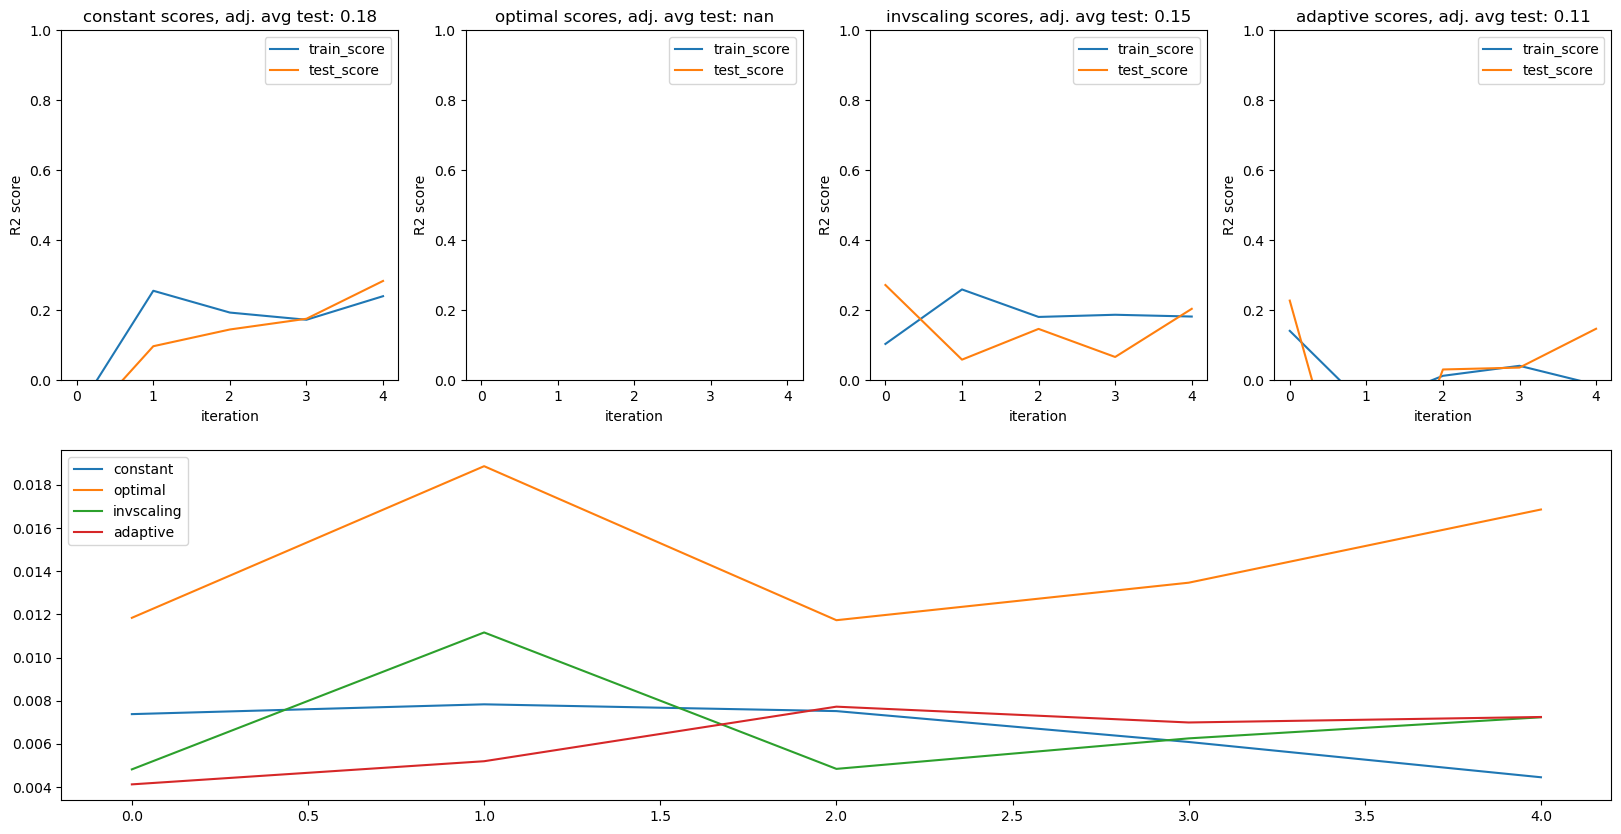

In [10]:
plotCVResults(cv_learning, ['constant','optimal','invscaling','adaptive'])

#### Watch out that your learning rates are not too high!!! Play with the variables if your code doesn't run too long. Alternative: Do a grid search.